# Setup

In [1]:
# Standard library imports
import warnings
import os
from random import gauss

# Third-party imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_process import ArmaProcess
from pandas.plotting import autocorrelation_plot
from pandas_datareader import data as pdr
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_absolute_error, mean_squared_error
from pmdarima.arima import auto_arima
from pmdarima import pipeline, model_selection, arima
from pmdarima import preprocessing as ppc

# Configuration & Settings
warnings.simplefilter(action='ignore', category=FutureWarning)

This block imports various modules necessary for time series analysis and machine learning tasks. 

The first section brings in standard Python libraries like `warnings` (to manage warning messages), `os` (for interacting with the operating system, though it isn’t directly used in this snippet), and `random` specifically the `gauss` function for generating normally distributed random numbers.

Next, several third-party packages are imported. `pandas` is utilized for data manipulation and analysis, particularly with DataFrames. `numpy` provides support for numerical operations and arrays. `matplotlib.pyplot` enables the creation of visualizations like plots and charts. 

The code also imports modules from `statsmodels`, a library focused on statistical modeling. These include functions for time series decomposition (`seasonal_decompose`), Augmented Dickey-Fuller tests for stationarity (`adfuller`), Autoregressive (AR) models (`AR`), AutoRegressive Moving Average (ARMA) processes (`ArmaProcess`), and SARIMAX models (`SARIMAX`). Functions for plotting autocorrelation and partial autocorrelation functions are also included.

`pandas_datareader` is imported as `pdr`, allowing the retrieval of financial data from online sources.  `sklearn.metrics` provides tools to evaluate model performance, specifically calculating mean absolute error and mean squared error. 

Finally, `pmdarima` is imported, a library designed for automated time series modeling, including functions for automatic ARIMA model selection (`auto_arima`), pipeline construction, model selection strategies, and preprocessing techniques.

The final line suppresses `FutureWarning` messages, which can clutter the output without necessarily indicating critical errors. This keeps the console cleaner during execution.

In [2]:
# general settings
class CFG:
    data_folder = './data/'
    img_dim1 = 20
    img_dim2 = 10
    SEED = 42


# display style 
plt.style.use("seaborn-v0_8")
plt.rcParams["figure.figsize"] = (CFG.img_dim1, CFG.img_dim2)

np.random.seed(CFG.SEED)

This code establishes general settings and visual preferences for a project involving data analysis and plotting. 

A class named `CFG` is defined to hold configuration variables. It specifies the location of the data folder as `./data/`, sets image dimensions to 20x10 (for visualizations), and defines a random seed value of 42 for reproducibility.

Following this, the code adjusts the plotting style using Matplotlib.  It applies the "seaborn-v0_8" style theme and configures the default figure size based on the `img_dim1` and `img_dim2` values defined in the `CFG` class – setting the standard width and height of plots to 20x10 inches.

Lastly, it sets the seed for NumPy’s random number generator using the value stored in `CFG.SEED`. This ensures that any randomized operations within the code will produce consistent results each time the program is run, aiding in debugging and reproducibility.

# Utils

In [3]:
def plot_acf_pacf(
    series,
    lags=20,
    title=None
):

    fig, axes = plt.subplots(2, 1, sharex=True)

    plot_acf(series, lags=lags, ax=axes[0])
    axes[0].set_title("Autocorrelation (ACF)")

    plot_pacf(series, lags=lags, ax=axes[1])
    axes[1].set_title("Partial Autocorrelation (PACF)")

    if title:
        fig.suptitle(title, fontsize=14)
        fig.tight_layout(rect=[0, 0, 1, 0.95])
    else:
        fig.tight_layout()

    plt.show()


This function generates and displays plots of the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) for a given time series. 

The function begins by creating a figure with two subplots arranged vertically, sharing the same x-axis. It then uses functions from the `statsmodels` library (`plot_acf` and `plot_pacf`) to generate the ACF plot on the top subplot and the PACF plot on the bottom subplot. Each subplot receives a descriptive title: "Autocorrelation (ACF)" and "Partial Autocorrelation (PACF)", respectively.

An optional `title` argument allows for an overarching title to be added to the entire figure using `fig.suptitle`. If a title is provided, the layout of the subplots is adjusted with `fig.tight_layout` to ensure the main title doesn’t overlap with the plots themselves.  If no title is given, a standard tight layout is applied.

Finally, `plt.show()` displays the generated figure containing both ACF and PACF plots. The `lags` parameter controls how many lags are displayed on each plot; its default value is 20. These plots are useful for identifying patterns of correlation within the time series data, which can inform choices about appropriate statistical models (like ARIMA) to use for forecasting or analysis.

In [4]:
def print_adf_result(data, name="Series"):
    # Handle NaN values automatically for differenced data
    data = data.dropna()
    result = adfuller(data)
    print(f'\n--- ADF Test: {name} ---')
    print(f'ADF Statistic: {result[0]:.6f}')
    print(f'p-value: {result[1]:.6f}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value:.3f}')

This function performs the Augmented Dickey-Fuller (ADF) test on a given time series and prints the results in a formatted way. The ADF test is used to determine if a time series is stationary, which is an important property for many time series models.

The function takes two arguments: `data`, which is the time series data to be tested, and `name`, which is an optional string providing a descriptive name for the series being analyzed (defaults to "Series"). 

First, `data = data.dropna()` removes any missing values (NaNs) from the input data. This is important because the ADF test cannot handle missing values.

Then, `result = adfuller(data)` performs the ADF test using the `adfuller` function from the `statsmodels` library. The result object contains various statistics related to the test. 

The code then prints a header indicating which series is being tested and proceeds to print key results: the ADF statistic, the p-value, and critical values at different significance levels (1%, 5%, and 10%).  The ADF statistic and p-value are formatted to six decimal places for readability. The critical values are printed with three decimal places.

By examining the p-value in relation to the chosen significance level, you can determine whether to reject or fail to reject the null hypothesis that the time series has a unit root (i.e., is non-stationary). If the p-value is less than the significance level, you reject the null hypothesis and conclude that the series is likely stationary.

In [5]:
def forecast_metrics(y_true, y_pred):
    return {
        "MAE": float(round(mean_absolute_error(y_true, y_pred), 2)),
        "RMSE": float(round(np.sqrt(mean_squared_error(y_true, y_pred)), 2)),
    }



This code defines a function called `forecast_metrics` that calculates and returns two common metrics used to evaluate the accuracy of time series forecasts: Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE).

The function takes two arguments: `y_true`, representing the actual observed values, and `y_pred`, representing the predicted values. 

Inside the function, it calculates the MAE using `mean_absolute_error(y_true, y_pred)` from the `sklearn.metrics` module. It then rounds the result to two decimal places using `round()` and converts it to a float.

Similarly, it computes the RMSE by first calculating the mean squared error using `mean_squared_error(y_true, y_pred)`, taking its square root using `np.sqrt()`, rounding the result to two decimal places, and converting it to a float. 

Finally, the function returns a dictionary containing these two metrics with keys "MAE" and "RMSE", providing a concise summary of forecast accuracy.

# Linear models

## AR processes

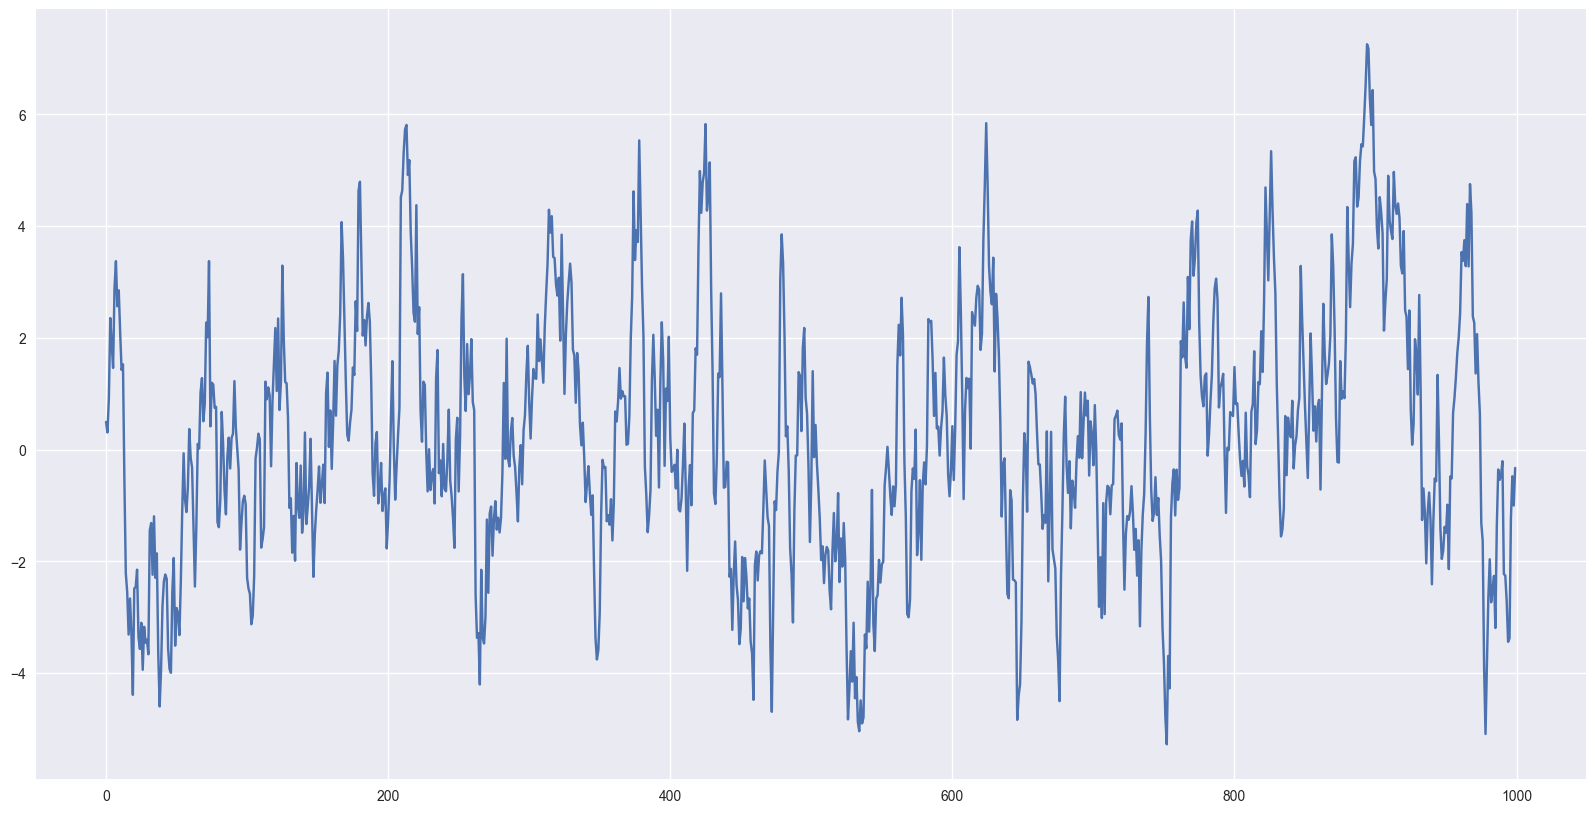

In [6]:
ar1 = np.array([1, -0.9])
ma1 = np.array([1])
AR_object1 = ArmaProcess(ar1, ma1)
simulated_data_1 = AR_object1.generate_sample(nsample=1000)
plt.plot(simulated_data_1)
plt.show()

This code simulates data from an autoregressive (AR) process and then visualizes the generated time series.

First, `ar1 = np.array([1, -0.9])` defines the coefficients for an AR(1) model. An AR(1) model means that the current value in the series is a linear combination of its immediately preceding value plus a constant term (which is implicitly 1 due to how the coefficients are used). In this case, the current value is equal to 1 times the previous value minus 0.9 times the previous value.

Next, `ma1 = np.array([1])` defines the coefficients for a moving average (MA) component of order 0. Since only one element exists in the array, it indicates there's no MA component; this effectively makes the model purely autoregressive.

The line `AR_object1 = ArmaProcess(ar1, ma1)` creates an object representing the ARMA process using the specified coefficients from the `statsmodels` library. 

Then, `simulated_data_1 = AR_object1.generate_sample(nsample=1000)` generates a time series of length 1000 samples based on the defined ARMA model. This simulates data that would be produced by this process if it were operating in reality.

Finally, `plt.plot(simulated_data_1)` plots the generated time series and `plt.show()` displays the plot, allowing you to visually inspect the simulated data. The resulting graph will show a fluctuating line representing the values of the time series over the 1000 samples. Because of the negative autocorrelation coefficient (-0.9), the series will exhibit some degree of persistence or correlation between consecutive values.

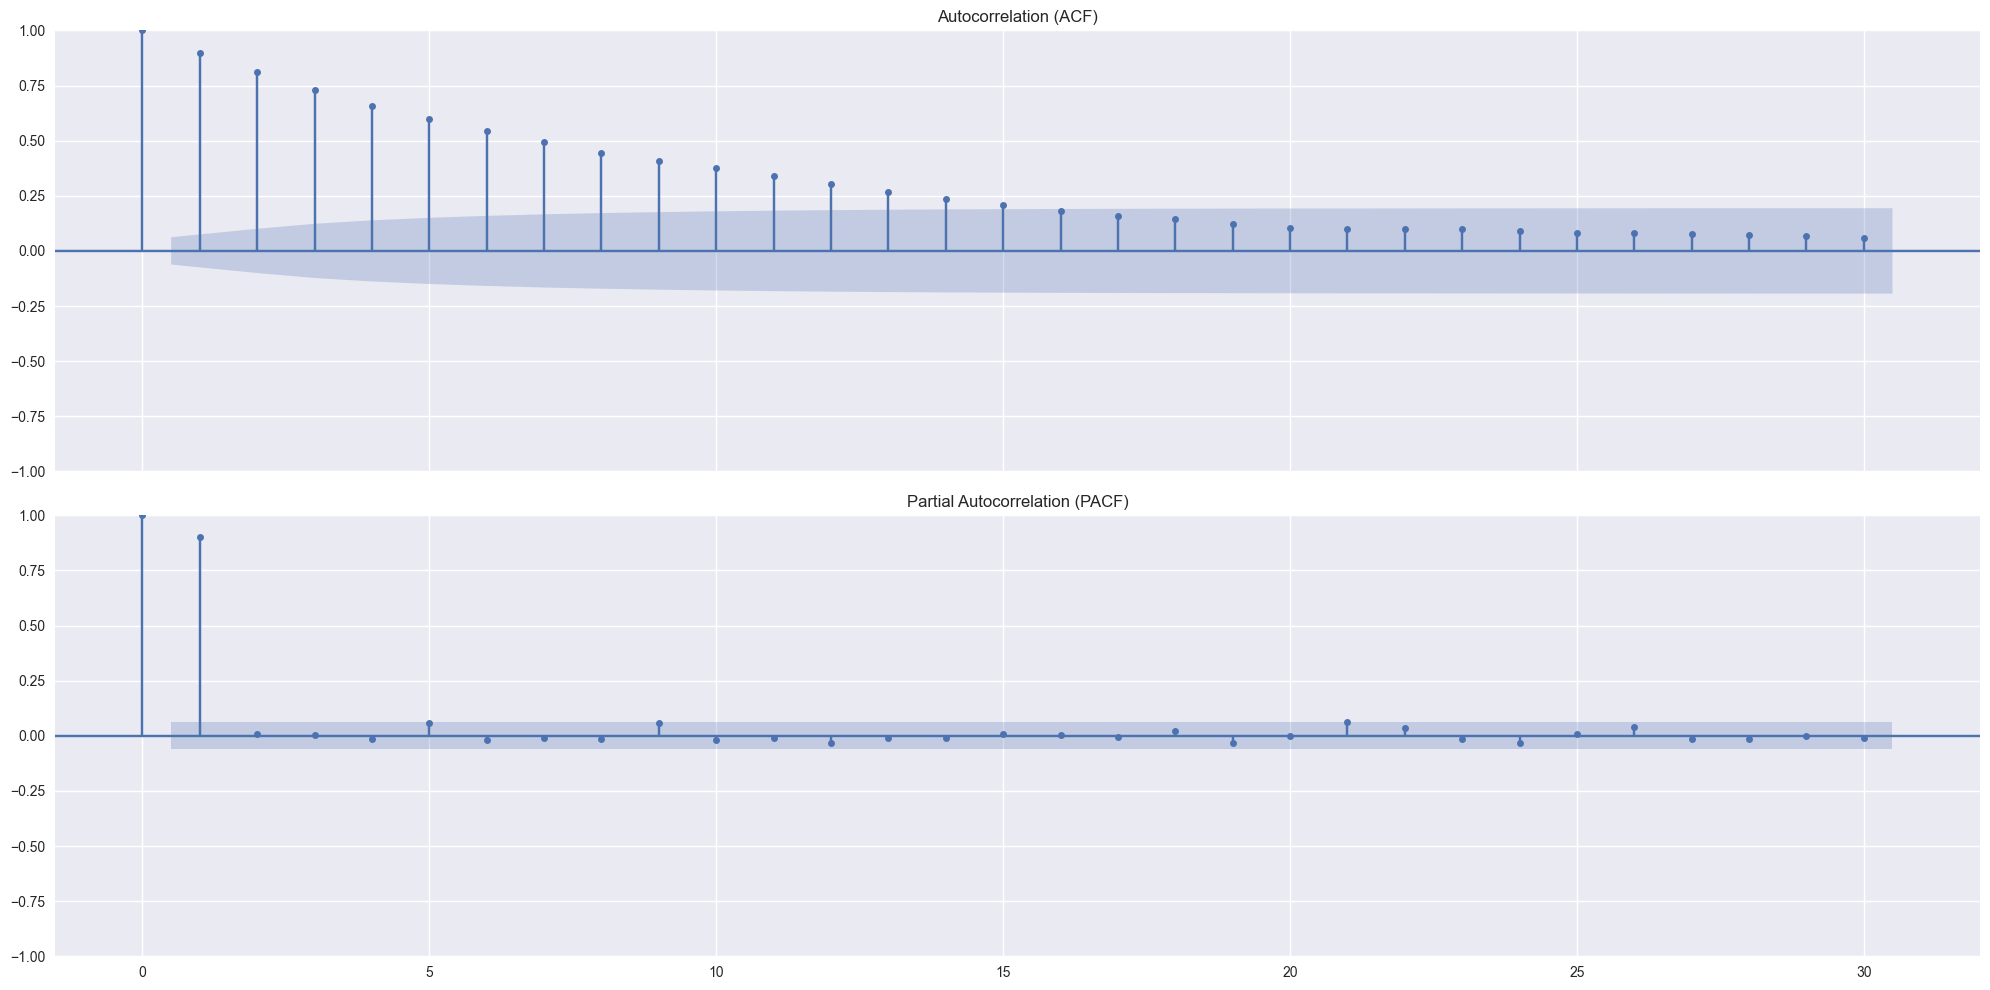

In [7]:
plot_acf_pacf(simulated_data_1, lags=30)

## MA processes

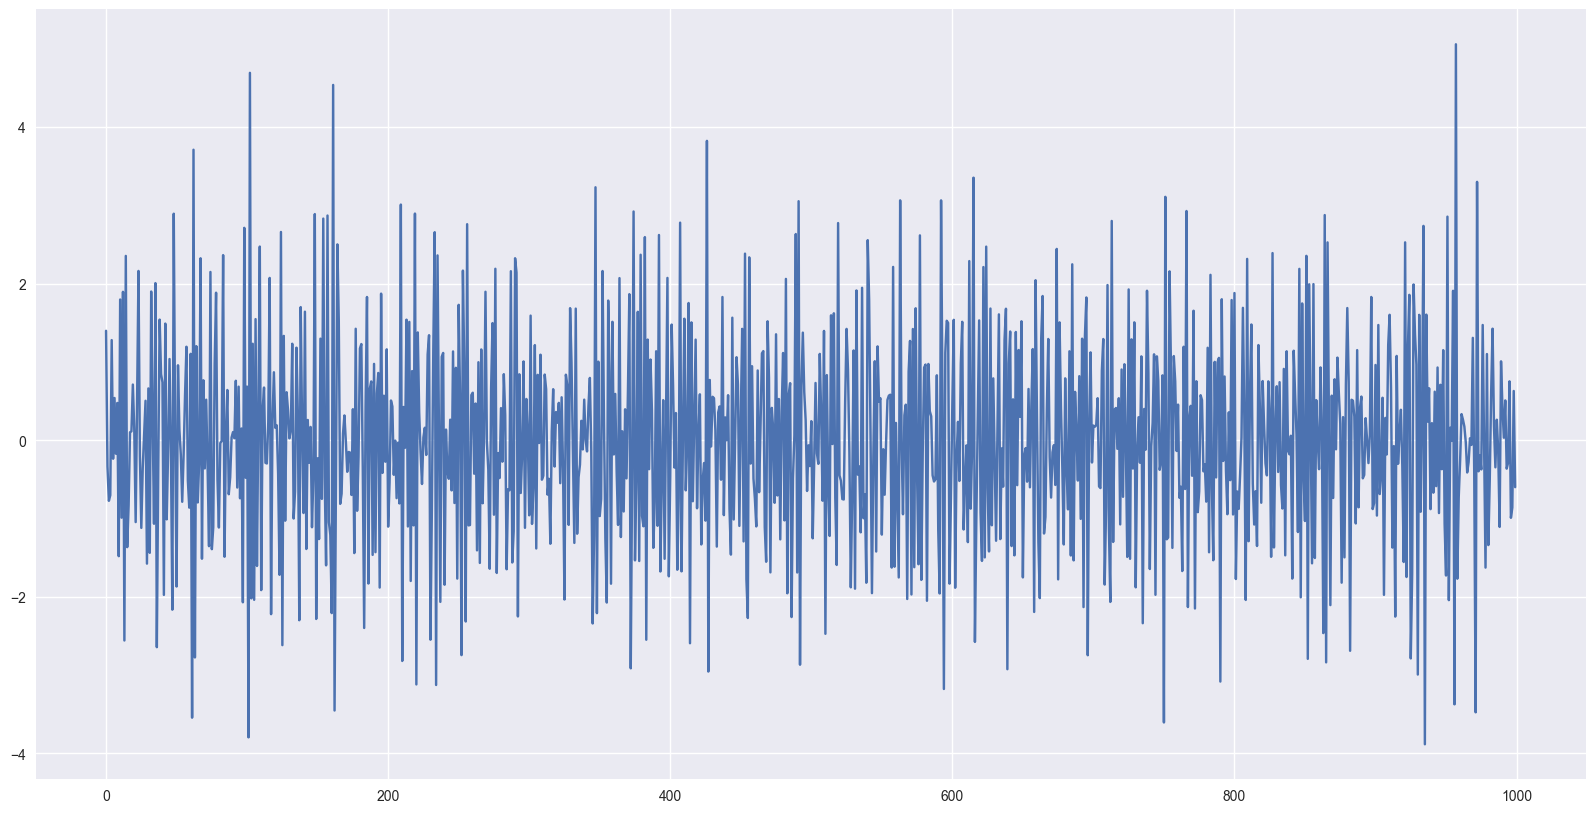

In [8]:
ar1 = np.array([1])
ma1 = np.array([1, -0.9])
MA_object1 = ArmaProcess(ar1, ma1)
simulated_data_2 = MA_object1.generate_sample(nsample=1000)
plt.plot(simulated_data_2)
plt.show()

This code simulates data from a moving average (MA) process and then displays the resulting time series as a plot.

The line `ar1 = np.array([1])` defines the autoregressive component of an ARMA model. Setting it to `[1]` indicates that there is no autoregressive part; the current value does not depend on past values of the series directly. 

Then, `ma1 = np.array([1, -0.9])` specifies the coefficients for a moving average (MA) component of order 1. An MA(1) model means that the current value is a linear combination of the current and one previous random shock (error term). In this case, the current value is equal to the current shock plus (-0.9) times the previous shock.

`MA_object1 = ArmaProcess(ar1, ma1)` creates an object representing the ARMA process using these coefficients from the `statsmodels` library. 

The line `simulated_data_2 = MA_object1.generate_sample(nsample=1000)` generates a time series of length 1000 samples based on this MA model, simulating data that would be produced by such a process.

Finally, `plt.plot(simulated_data_2)` plots the generated time series and `plt.show()` displays the plot. The resulting graph will show a fluctuating line representing the values of the time series over 1000 samples. Because of the MA component, the series will exhibit short-term correlations; a positive shock today will be followed by a negative shock tomorrow with some probability due to the -0.9 coefficient.

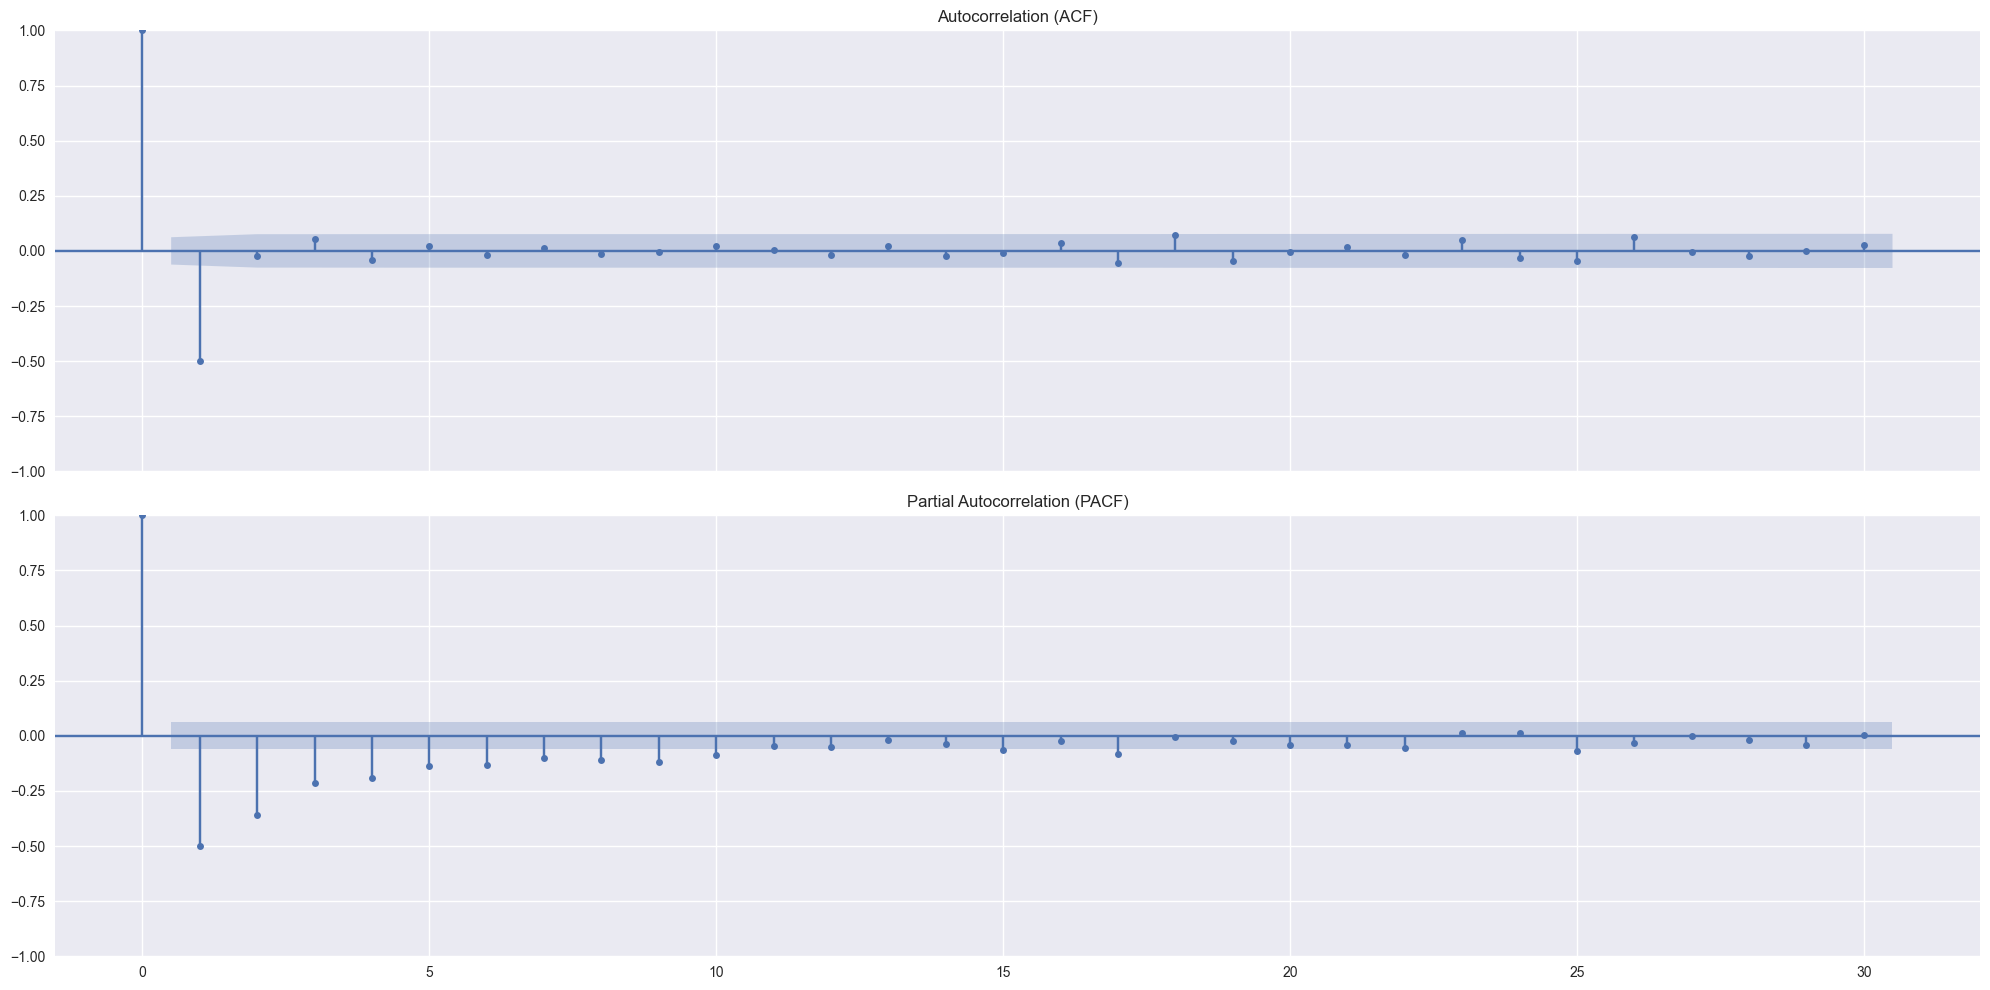

In [9]:
plot_acf_pacf(simulated_data_2, lags=30)

## ARMA

<Axes: xlabel='date'>

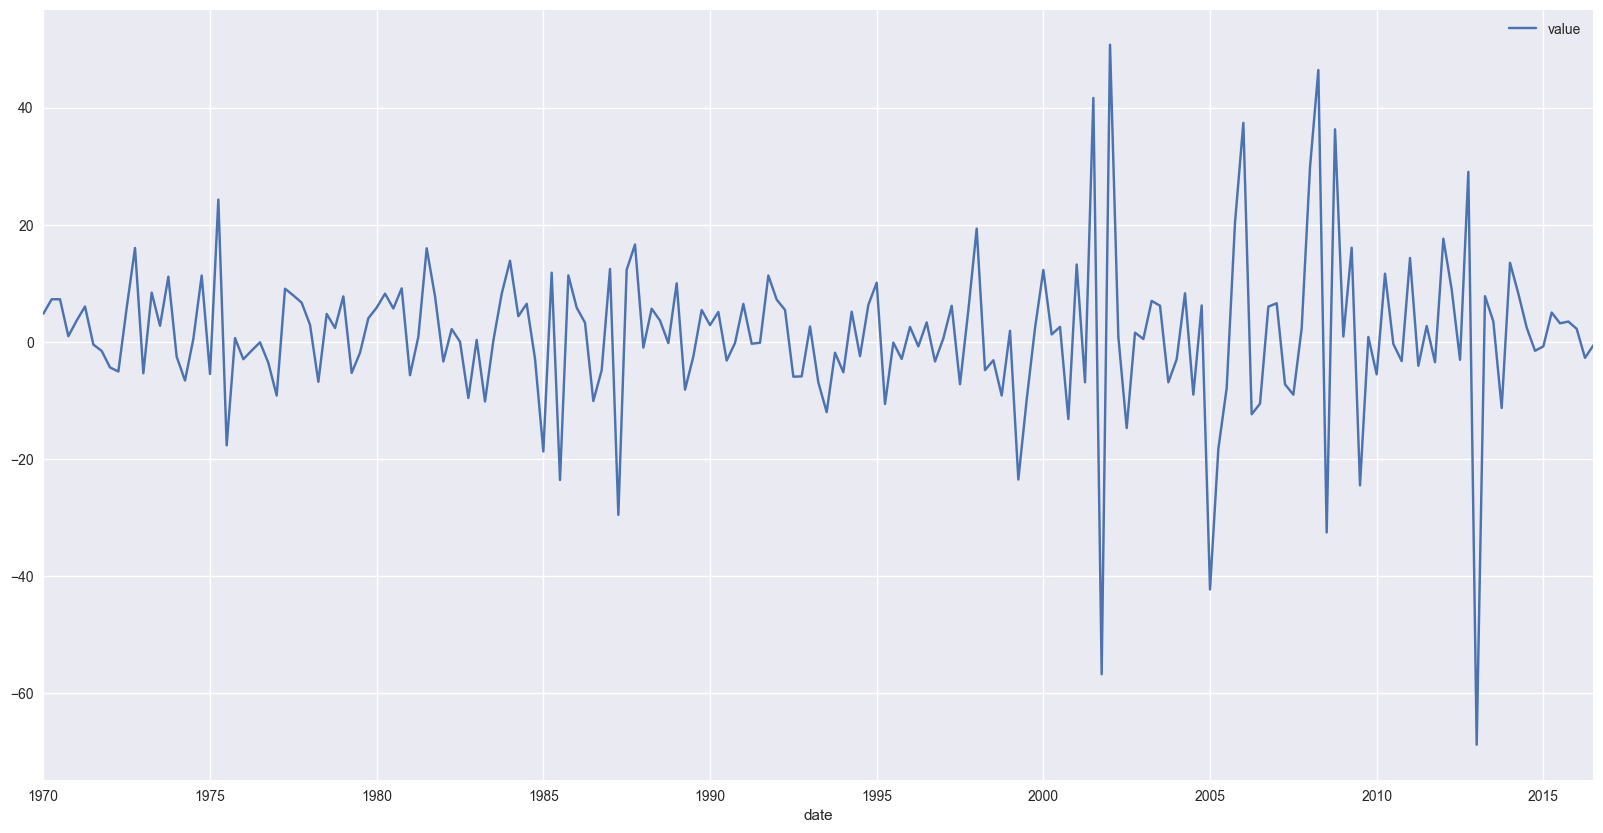

In [10]:
xdat = pd.read_csv(CFG.data_folder + 'savings_change.csv')

xdat.columns = ['date', 'value']
xdat['date'] = pd.to_datetime(xdat['date'])

xdat.set_index('date').plot()

This code reads time series data from a CSV file, prepares it for analysis, and then generates a line plot of the data over time. 

First, `xdat = pd.read_csv(CFG.data_folder + 'savings_change.csv')` reads the data from a CSV file named "savings_change.csv". The location of this file is determined by combining the value of `CFG.data_folder` (which is assumed to be a pre-defined path) with the filename. This data is stored in a Pandas DataFrame called `xdat`.

Next, `xdat.columns = ['date', 'value']` assigns column names "date" and "value" to the columns of the DataFrame. It’s assuming that the CSV file either doesn't have headers or has headers that should be replaced with these names. 

The line `xdat['date'] = pd.to_datetime(xdat['date'])` converts the 'date' column from its original data type (likely strings) to a datetime format, which is essential for time series analysis and plotting. This allows Pandas to correctly interpret dates and times.

Finally, `xdat.set_index('date').plot()` sets the 'date' column as the index of the DataFrame and then generates a line plot using the default plotting functionality of Pandas. The x-axis of the plot will represent the dates, and the y-axis will represent the corresponding values from the 'value' column. This visualization allows for easy inspection of how the savings change data evolves over time.

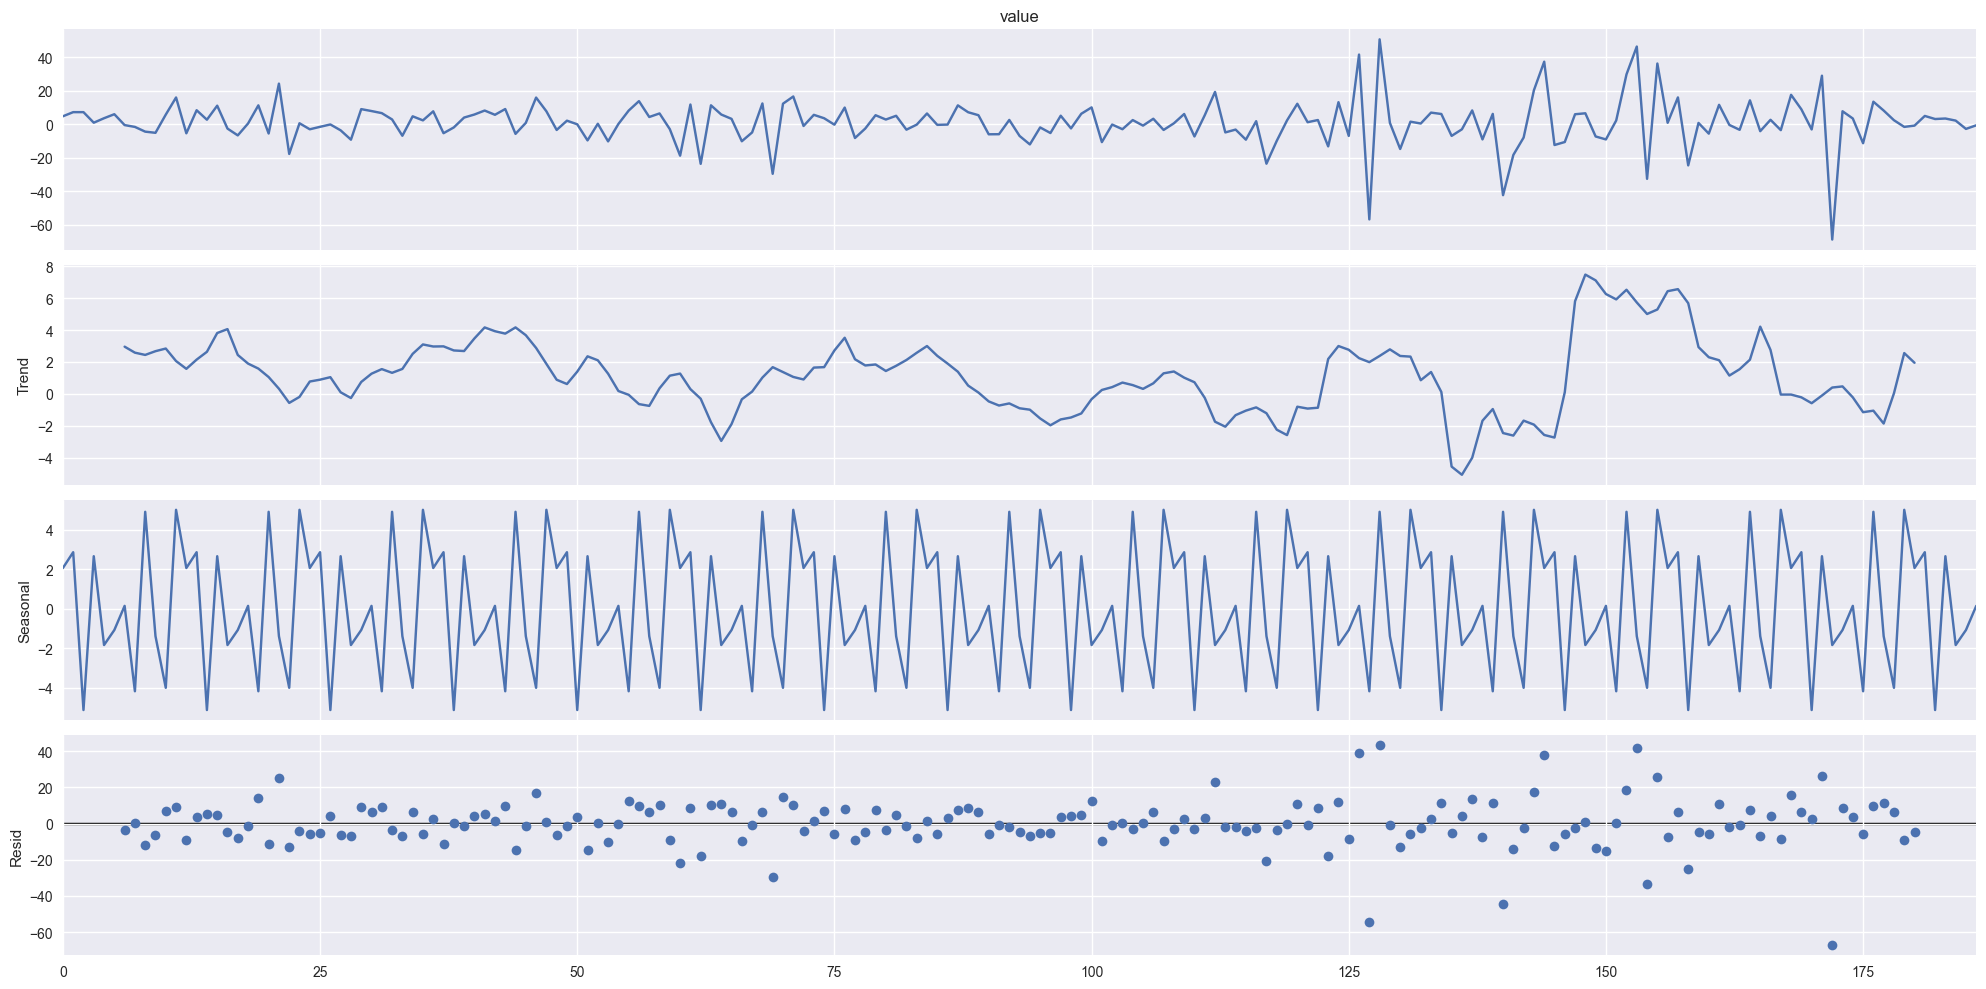

In [11]:
decomposition = seasonal_decompose(xdat["value"],period =12, model = 'additive') 
figure = decomposition.plot()
plt.show()

This code performs a seasonal decomposition of a time series and then visualizes the results.

`decomposition = seasonal_decompose(xdat["value"], period=12, model='additive')` applies a seasonal decomposition to the 'value' column of the `xdat` DataFrame using the `seasonal_decompose` function from the `statsmodels` library. The `period=12` argument specifies that the seasonality is assumed to be yearly (12 months). The `model='additive'` argument indicates that the time series is modeled as a sum of its trend, seasonal, and residual components:  Value = Trend + Seasonality + Residual.

The line `figure = decomposition.plot()` generates a plot showing the decomposed components – the original time series, the estimated trend component, the estimated seasonal component, and the residuals (the remaining variation not explained by the trend or seasonality). The function returns a Matplotlib figure object containing these subplots. 

Finally, `plt.show()` displays the generated plot, allowing you to visually inspect each of the decomposed components and understand the underlying patterns in the time series data. This is useful for identifying trends, seasonal fluctuations, and any remaining irregular variations within the savings change data.

In [12]:
print_adf_result(xdat['value'])


--- ADF Test: Series ---
ADF Statistic: -18.705760
p-value: 0.000000
Critical Values:
	1%: -3.466
	5%: -2.877
	10%: -2.575


This line of code executes the `print_adf_result` function with the 'value' column from the `xdat` DataFrame as input. 

Specifically, it passes the time series data contained in `xdat['value']` to the function. This will perform an Augmented Dickey-Fuller (ADF) test on this time series and print the results – including the ADF statistic, p-value, and critical values – to the console. The output will help determine whether the 'value' column of your data is stationary or not. Because no `name` argument is provided, the function will label the analysis as being performed on "Series".

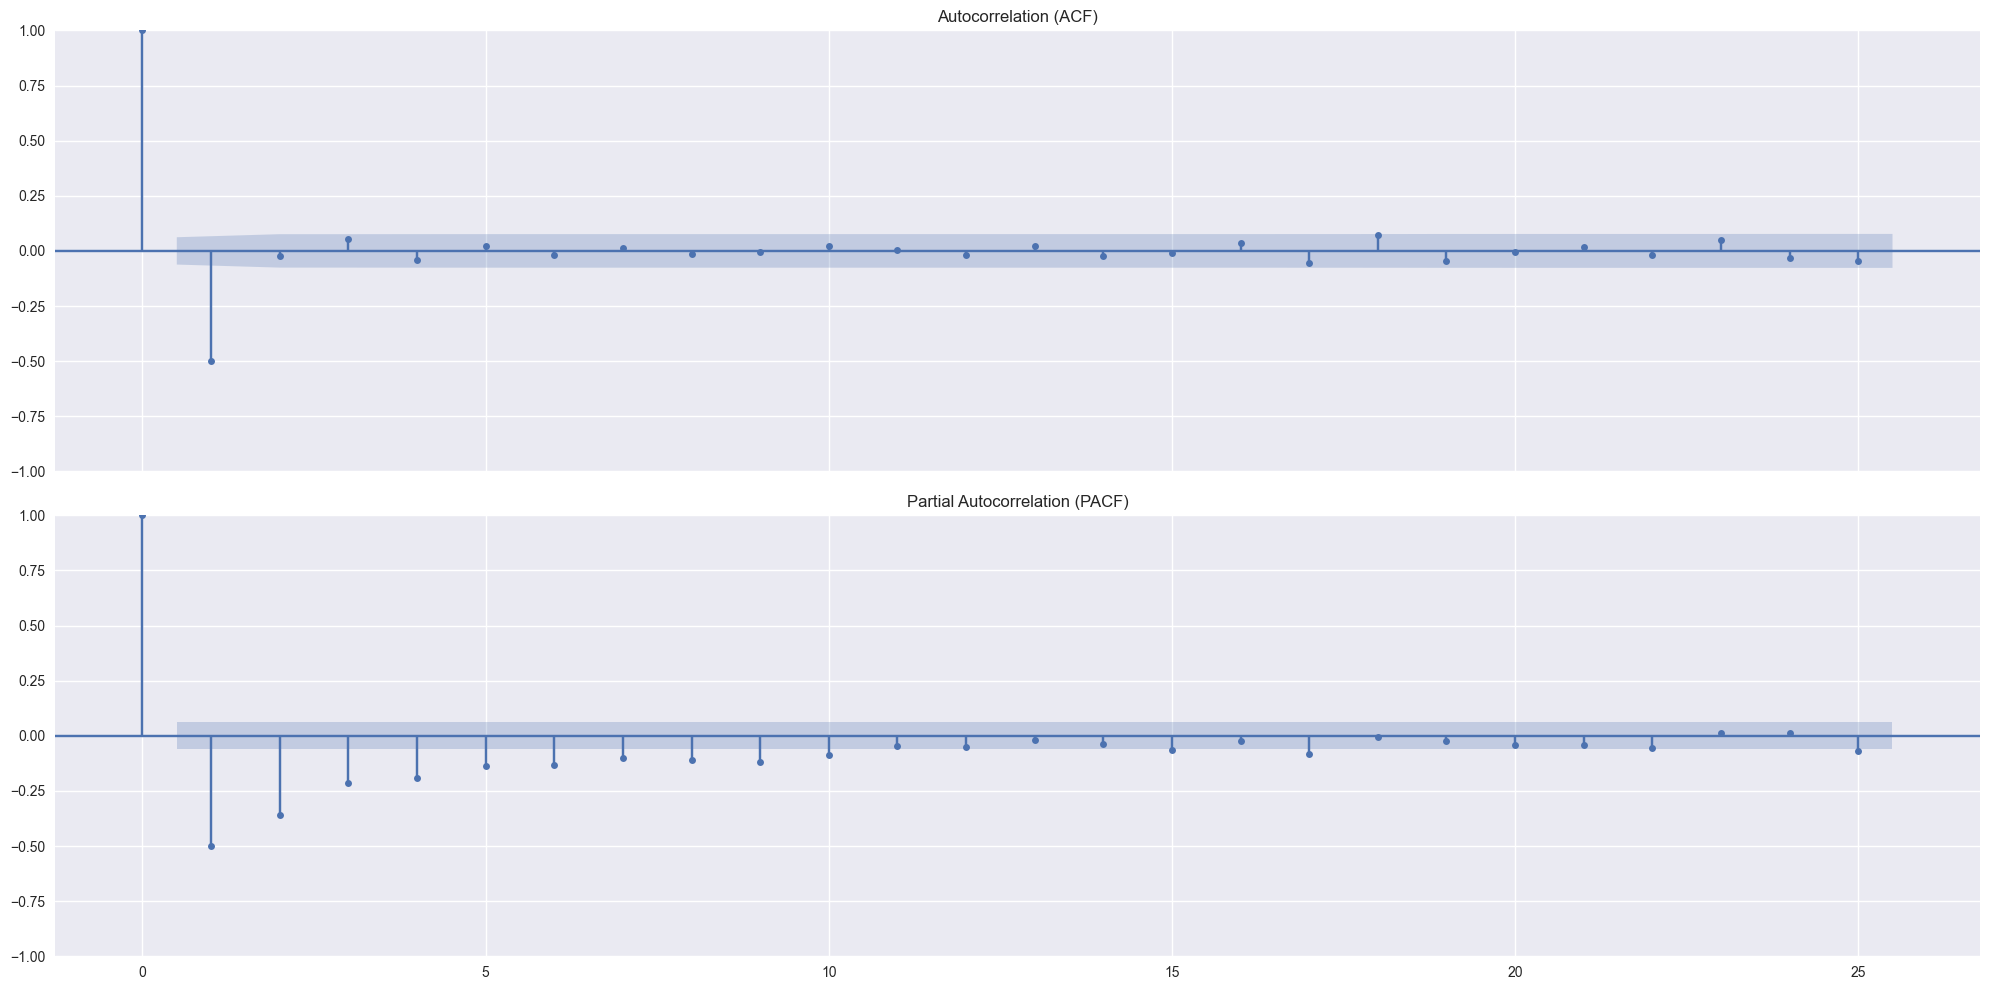

In [13]:
plot_acf_pacf(simulated_data_2, lags=25)

In [14]:

xtrain, xvalid = model_selection.train_test_split(xdat['value'], test_size = 12)



`xtrain, xvalid = model_selection.train_test_split(xdat['value'], test_size=12)` uses the `train_test_split` function from the `sklearn.model_selection` module to perform this split. 

The first argument, `xdat['value']`, is the time series data that will be divided. The `test_size=12` argument specifies that the validation set (`xvalid`) should contain the last 12 observations from the time series. Consequently, the remaining observations are assigned to the training set (`xtrain`).

This approach ensures that the model is trained on historical data and then evaluated on more recent data it hasn't seen before, simulating a real-world forecasting scenario where you’re predicting future values based on past patterns. The holdout period of 12 months allows for assessing how well the model generalizes to unseen data from the same time frame as the seasonality identified earlier (period=12).

In [15]:
# construct a pipeline, combining feature preprocessing and the model to fit
pipe = pipeline.Pipeline([
    ("fourier", ppc.FourierFeaturizer(m=4)),
    ("arima", arima.AutoARIMA(stepwise=True, trace=1, error_action="ignore",
                              seasonal=False,  
                              suppress_warnings=True))
])

pipe.fit(xtrain)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1417.652, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1428.604, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1413.626, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1414.732, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=1415.564, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1415.511, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=1417.401, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1413.240, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1429.318, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=1415.233, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1415.223, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1413.866, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1417.096, Time=0.06 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.275 seconds


,steps,"[('fourier', ...), ('arima', ...)]"


This code constructs and fits a machine learning pipeline for time series forecasting using the AutoARIMA model with Fourier features. 

First, `pipe = pipeline.Pipeline([...])` creates a scikit-learn Pipeline object. Pipelines allow you to chain together multiple data processing steps and a final estimator (the model) into a single workflow.

Inside the Pipeline, two steps are defined:
1. `"fourier", ppc.FourierFeaturizer(m=4)`: This step uses `FourierFeaturizer`. It transforms the time series data by adding Fourier features (sine and cosine waves) with frequencies up to `m=4`. These features can help capture seasonal patterns in the data.
2. `"arima", arima.AutoARIMA(...)`: This step uses the `AutoARIMA` model from the `pmdarima` library.  The parameters configure the AutoARIMA process:
    - `stepwise=True`: Uses a stepwise search to find the optimal ARIMA order.
    - `trace=1`: Prints information about the search process (verbosity level).
    - `error_action="ignore"`: Ignores errors during model fitting, which can happen if certain parameter combinations lead to invalid models.
    - `seasonal=False`:  Specifies that no seasonal component should be considered in the ARIMA model. This is likely because seasonality has already been addressed by the Fourier features.
    - `suppress_warnings=True`: Suppresses warnings generated during the AutoARIMA process.

Finally, `pipe.fit(xtrain)` trains the pipeline on the training data (`xtrain`).  This involves first applying the Fourier feature transformation to the training data and then using the transformed data to fit the AutoARIMA model by finding its optimal parameters. The fitted pipeline is now ready for making predictions.

In [16]:
# we can inspect the results
pipe.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  175
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -699.620
Date:                Mon, 19 Jan 2026   AIC                           1413.240
Time:                        23:23:49   BIC                           1435.394
Sample:                             0   HQIC                          1422.226
                                - 175                                         
Covariance Type:                  opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept        1.5503      1.091      1.421      0.155      -0.588       3.689
FOURIER_S4-0     2.2632      1.465      1.545      0.122      -0.609       5.135
FOURIER_C4-0     0.6652      1.497      0.444      0.657      -2.268       3.599
FOURIER_S4-1  9.682e+04   3.97e+05      0.244      0.808   -6.82e+05    8.76e+05
FOURIER_C4-1    -0.0559      4.481     -0.012      0.990      -8.839       8.727
ar.L1           -0.3125      0.043     -7.312      0.000      -0.396      -0.229
sigma2         173.6642     11.068     15.691      0.000     151.972     195.357
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               206.40
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               6.35   Skew:                            -0.35
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [17]:
# we compute predictions from the pipeline object
preds, conf_int = pipe.predict(n_periods= xvalid.shape[0], return_conf_int=True)

# combine the data
results_df = pd.DataFrame({ 'actual': xvalid.values,
    'predicted': preds,  'lower CI': conf_int[:, 0],  'upper CI': conf_int[:, 1] })

This code generates forecasts using a trained pipeline and organizes the results into a Pandas DataFrame for analysis.

First, `preds, conf_int = pipe.predict(n_periods= xvalid.shape[0], return_conf_int=True)` uses the fitted pipeline (`pipe`) to predict future values. The `n_periods` argument is set to the length of the validation dataset (`xvalid.shape[0]`), meaning it generates predictions for each point in the holdout period.  The `return_conf_int=True` flag ensures that confidence intervals are also calculated alongside the forecasts.

Next, `results_df = pd.DataFrame({...})` creates a Pandas DataFrame to store and organize the results. The dictionary passed to `pd.DataFrame()` defines the columns of this new table:
- `'actual': xvalid.values`: This column contains the true values from the validation set (`xvalid`).  `.values` converts the Pandas Series into a NumPy array.
- `'predicted': preds`: This column holds the forecasts generated by the pipeline.
- `'lower CI': conf_int[:, 0]`: This column stores the lower bounds of the confidence intervals for each prediction. `conf_int[:, 0]` selects all rows and the first column from the `conf_int` array, which represents these lower bounds.
- `'upper CI': conf_int[:, 1]`:  This column contains the upper bounds of the confidence intervals. `conf_int[:, 1]` extracts the second column from the `conf_int` array, representing the upper bounds.

The resulting DataFrame, `results_df`, provides a clear and structured way to compare predicted values with actual values and assess the uncertainty associated with those predictions through the confidence intervals. This is ideal for evaluating model performance and visualizing forecast accuracy.

In [18]:
results_df

,actual,predicted,lower CI,upper CI
175,-11.276615,1.404690,-24.424053,27.233433
176,13.520202,2.588137,-24.472635,29.648909
177,8.244048,1.783539,-25.394578,28.961656
178,2.461953,-2.484031,-29.673583,24.705520
179,-1.513050,3.296285,-23.894383,30.486953
180,-0.758400,1.973680,-25.217097,29.164457
181,5.023918,1.998851,-25.191937,29.189639
182,3.180930,-2.574599,-29.765388,24.616190
183,3.482786,3.347867,-23.842922,30.538656
184,2.236534,1.934282,-25.256507,29.125072


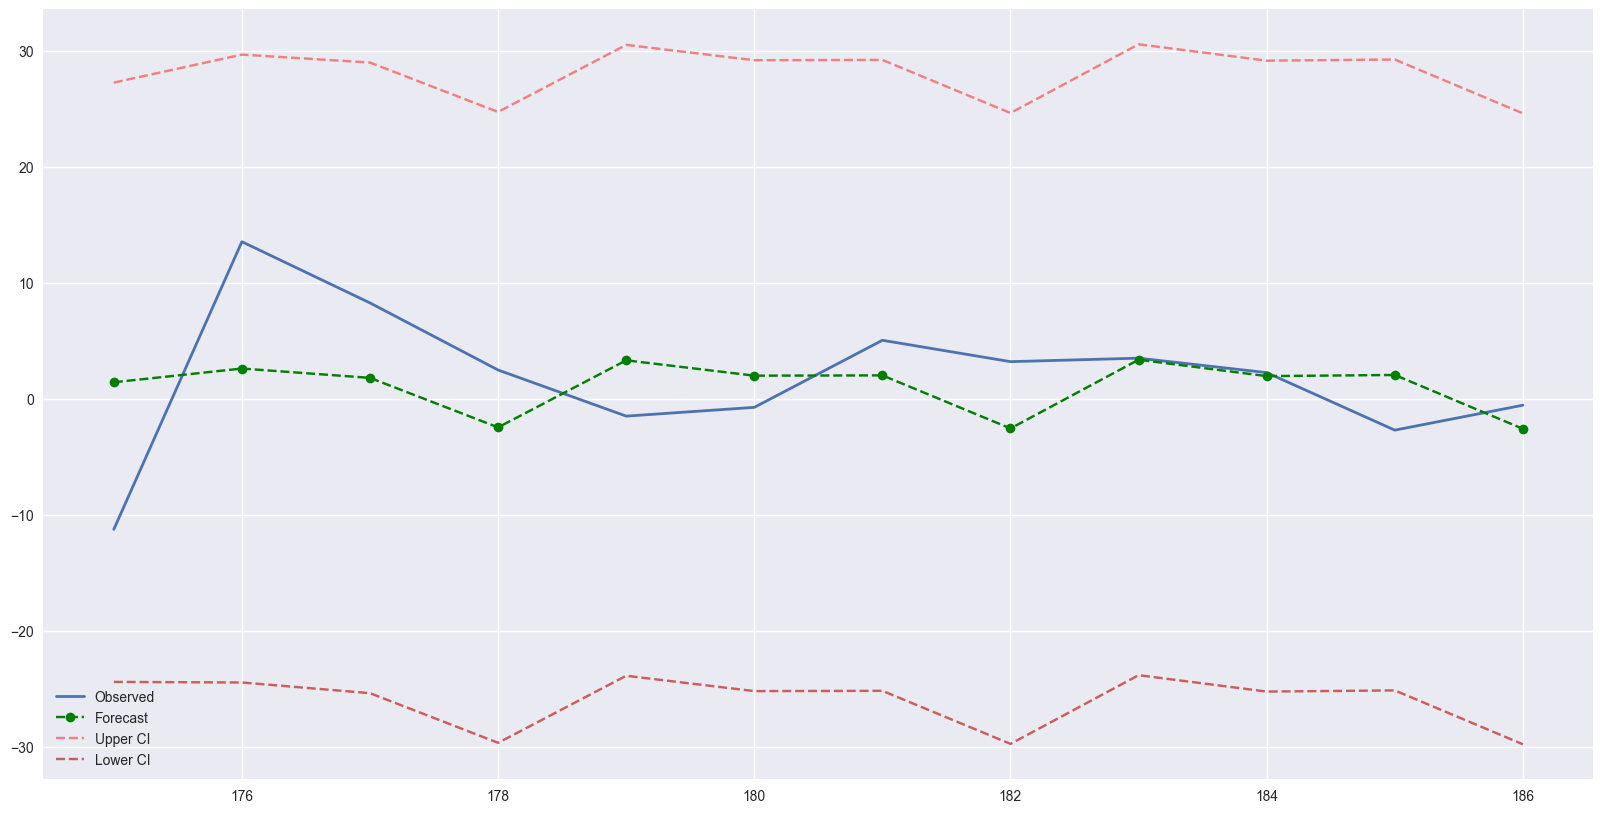

In [19]:
plt.figure()

# Original series
results_df["actual"].plot( label="Observed", linewidth=2, )
# Forecast
results_df["predicted"].plot( label="Forecast", marker="o", linestyle="--", color="green" )
# CI
results_df["upper CI"].plot( label="Upper CI", linestyle="--", color="lightcoral" )
results_df["lower CI"].plot( label="Lower CI", linestyle="--", color="indianred" )
plt.legend()
plt.show()

This code generates a plot visualizing the observed data, the forecasts generated by the model, and the confidence intervals around those forecasts.

`plt.figure()` creates a new figure for the plot. 

The following lines use the `plot` method of Pandas Series to add different components to the same plot:
- `results_df["actual"].plot( label="Observed", linewidth=2, )`: Plots the actual values from the validation set as a solid line with a width of 2 pixels. It's labeled "Observed" in the legend.
- `results_df["predicted"].plot( label="Forecast", marker="o", linestyle="--", color="green" )`: Plots the predicted values as a dashed line with circular markers, colored green.  It’s labeled “Forecast” in the legend.
- `results_df["upper CI"].plot( label="Upper CI", linestyle="--", color="lightcoral" )`: Plots the upper bound of the confidence interval as a dashed line, colored light coral. It's labeled "Upper CI" in the legend.
- `results_df["lower CI"].plot( label="Lower CI", linestyle="--", color="indianred" )`: Plots the lower bound of the confidence interval as a dashed line, colored indian red.  It’s labeled “Lower CI” in the legend.

`plt.legend()` adds a legend to the plot, which identifies each line based on its label. 

Finally, `plt.show()` displays the generated plot, allowing you to visually assess how well the forecasts align with the observed data and the range of uncertainty represented by the confidence intervals. This visualization is crucial for evaluating the model's performance and understanding the reliability of its predictions.

# Beyond ARMA

## ARIMA

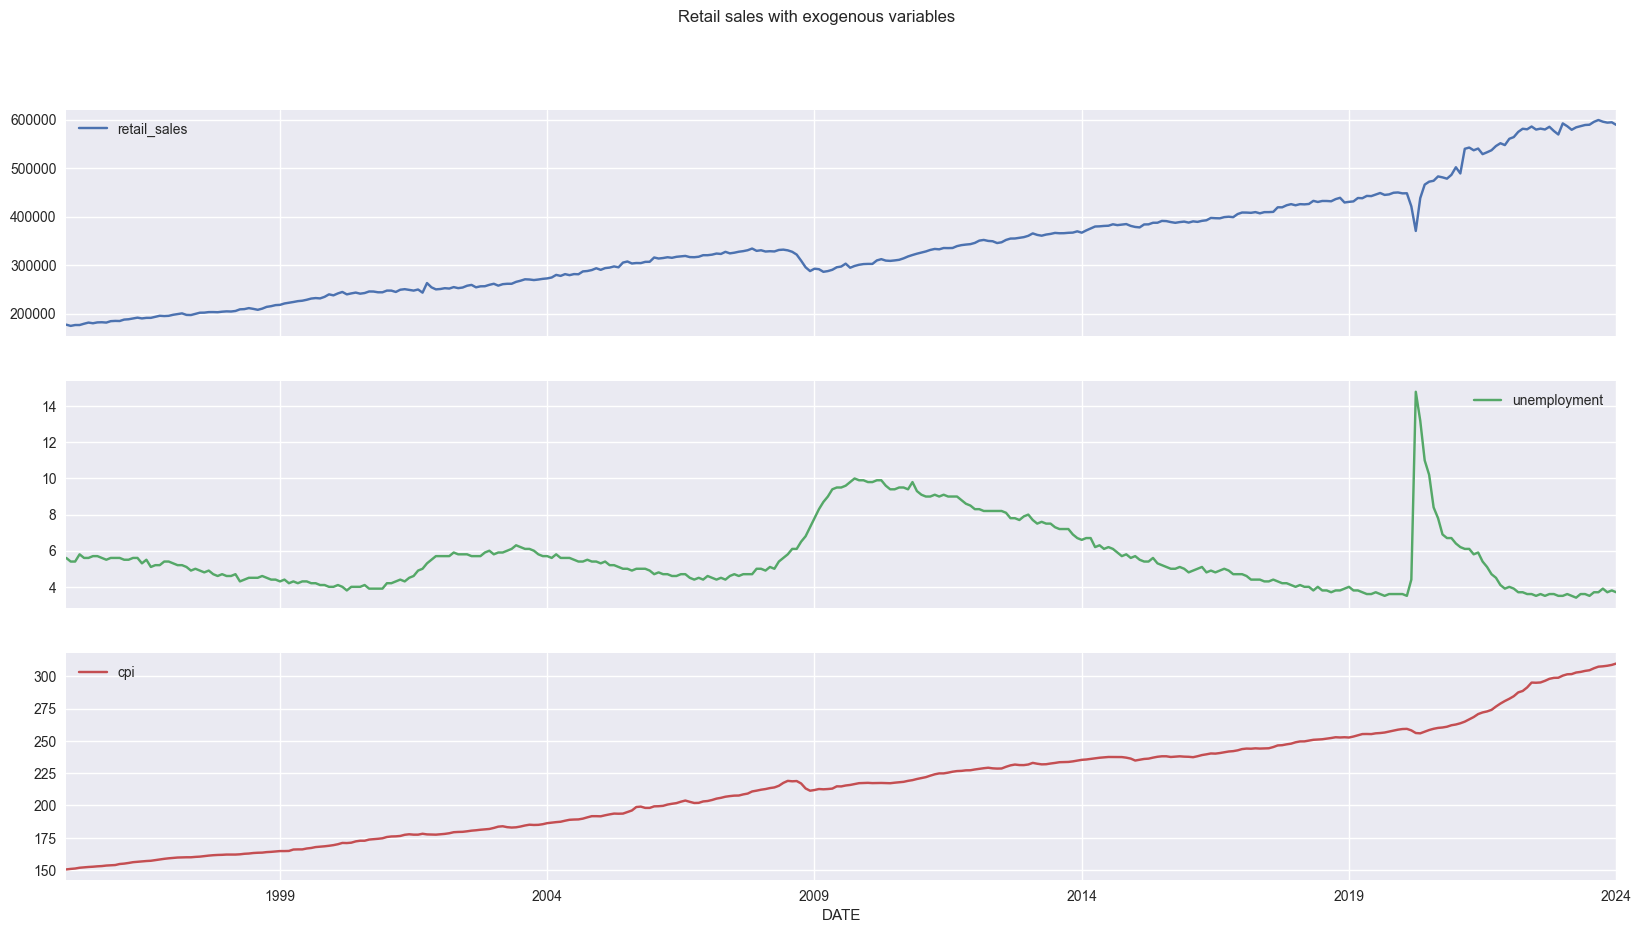

In [20]:
# time range
start = "1995-01-01"
end = "2024-01-01"

y = pdr.DataReader("RSXFS", "fred", start, end)  # Retail sales
x1 = pdr.DataReader("UNRATE", "fred", start, end)  # Unemployment
x2 = pdr.DataReader("CPIAUCSL", "fred", start, end)  # Inflation

# arrange into a single dataframe
df = pd.concat([y, x1, x2], axis=1)
df.columns = ["retail_sales", "unemployment", "cpi"]
df = df.dropna()

df.plot(subplots=True, figsize=(CFG.img_dim1, CFG.img_dim2), title="Retail sales with exogenous variables")
plt.show()

This section of code focuses on acquiring and preparing time series data for analysis. 

It first defines a start date ("1995-01-01") and an end date ("2024-01-01"), establishing the period for which data will be collected. Then, it uses `pandas_datareader` to download three time series from the Federal Reserve Economic Data (FRED) database. “RSXFS” represents retail sales, "UNRATE" is the unemployment rate, and "CPIAUCSL" signifies the Consumer Price Index (a measure of inflation). 

These three separate time series are then combined into a single `pandas` DataFrame named `df`. The `pd.concat` function joins them column-wise (`axis=1`).  The columns of this new DataFrame are renamed to "retail_sales", "unemployment", and "cpi" for clarity. 

Any rows containing missing values (NaN) are removed using `df.dropna()`, ensuring that all subsequent analyses are performed on complete data.

Finally, the code generates a visualization of the time series. The `df.plot` function creates subplots for each variable ("retail_sales", "unemployment", and "cpi") within the same figure.  The plot’s dimensions are determined by variables named `CFG.img_dim1` and `CFG.img_dim2`, and a title is added to the overall figure. The `plt.show()` command displays the generated plot.

In [21]:
train = df.iloc[:-24]
test = df.iloc[-24:]

y_train = train["retail_sales"]
y_test = test["retail_sales"]

X_train = train[["unemployment", "cpi"]]
X_test = test[["unemployment", "cpi"]]


This code segment divides the dataset into training and testing sets, and then separates the target variable from the predictor variables for both sets. 

It begins by splitting the DataFrame `df` into two parts: a training set (`train`) containing all data except the last 24 observations, and a test set (`test`) consisting of those final 24 observations. This is done using `.iloc`, which allows selection based on integer position.

Next, it isolates the "retail_sales" column from both the `train` and `test` DataFrames, assigning them to `y_train` and `y_test` respectively. These variables will serve as the target variable – the value being predicted – in the modeling process. 

Finally, it extracts the "unemployment" and "cpi" columns from both the training and testing sets, storing them in `X_train` and `X_test`.  These two columns are designated as the predictor variables (also known as features or independent variables) that will be used to predict retail sales.

In [22]:
print_adf_result(df['retail_sales'])


--- ADF Test: Series ---
ADF Statistic: 0.987842
p-value: 0.994136
Critical Values:
	1%: -3.450
	5%: -2.870
	10%: -2.571


In [23]:
pipe1 = arima.AutoARIMA(stepwise=True, trace=1, error_action="ignore",
                        seasonal= False,  max_p=  2, max_q=2 , 
                        suppress_warnings=True)

pipe1.fit(y_train.values)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=6647.848, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6643.812, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6644.308, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6644.227, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6651.409, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6646.445, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.063 seconds


,start_p,2
,d,None
,start_q,2
,max_p,2
,max_d,2
,max_q,2
,start_P,1
,D,None
,start_Q,1
,max_P,2
,max_D,1


This code utilizes the `pmdarima` library to automatically identify and fit an ARIMA model to the retail sales training data.

First, an `AutoARIMA` object named `pipe1` is created. Several parameters are specified during initialization: 

*   `stepwise=True`: This instructs the algorithm to use a stepwise search process for identifying the optimal model order, which is generally faster than other methods.
*   `trace=1`:  This setting enables verbose output during the model selection process, displaying information about each model tested.
*   `error_action="ignore"`: If an error occurs during model fitting, it will be ignored and the algorithm will continue searching for a suitable model.
*   `seasonal=False`: This indicates that the model should not consider any seasonal components in the data. 
*   `max_p=2`, `max_q=2`: These parameters limit the maximum order of the autoregressive (p) and moving average (q) components, respectively, to a value of 2.  This constrains the search space for model orders.
*   `suppress_warnings=True`: This prevents warning messages from being displayed during the process.

The `fit()` method is then called on `pipe1`, passing in the values of the `y_train` time series (converted to a NumPy array using `.values`).  This initiates the automated model selection and fitting procedure, resulting in an ARIMA model tailored to the training data. The best-performing model based on the specified criteria will be stored within the `pipe1` object.

In [24]:
model_arima = SARIMAX(y_train, order=(0, 1, 0))
result_arima = model_arima.fit()
print(result_arima.summary())

                               SARIMAX Results                                
Dep. Variable:           retail_sales   No. Observations:                  325
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -3324.704
Date:                Mon, 19 Jan 2026   AIC                           6651.409
Time:                        23:23:50   BIC                           6655.190
Sample:                    01-01-1995   HQIC                          6652.918
                         - 01-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      4.777e+07   7.71e+05     61.958      0.000    4.63e+07    4.93e+07
Ljung-Box (L1) (Q):                   1.80   Jarque-Bera (JB):             28980.14
Prob(Q):                              0.18   Pr

/Users/kbanachewicz/Documents/time-series-with-Konrad/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/kbanachewicz/Documents/time-series-with-Konrad/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


This code segment fits a Seasonal Autoregressive Integrated Moving Average (SARIMA) model to the retail sales training data and then displays a summary of the fitted model's results.

A `SARIMAX` object named `model_arima` is created, initialized with the `y_train` time series as the dependent variable. The `order` parameter specifies the non-seasonal components of the ARIMA model: (0, 1, 0). This indicates a model with zero autoregressive terms (AR), one integration term (I – representing differencing to achieve stationarity), and zero moving average terms (MA).  Because no seasonal order is specified, this effectively becomes a standard ARIMA(0,1,0) model.

The `fit()` method is then called on `model_arima` to estimate the model parameters based on the training data. The result of the fitting process is stored in the `result_arima` object. 

Finally, `print(result_arima.summary())` displays a comprehensive summary of the fitted SARIMA model. This summary includes information such as the estimated coefficients for each parameter, standard errors, t-statistics, p-values, confidence intervals, and various diagnostic statistics related to the model's fit and performance. It provides insights into the significance and reliability of the estimated parameters.

In [25]:
forecast_arima = result_arima.get_forecast(steps=len(y_test)).predicted_mean
forecast_metrics(y_test,forecast_arima)

{'MAE': 24178.58, 'RMSE': 25608.27}

This code generates forecasts using the fitted ARIMA model and then evaluates their accuracy against the actual test data.

First, `result_arima.get_forecast(steps=len(y_test))` is used to generate predictions for a number of steps equal to the length of the `y_test` time series (the test set). This creates a forecast object containing predicted values for each period in the test set. The `.predicted_mean` attribute extracts the point forecasts – the average predicted value for each future time step – from this forecast object, and assigns them to the variable `forecast_arima`.

Next, the `forecast_metrics` function (defined previously) is called with `y_test` as the actual values and `forecast_arima` as the predicted values. This calculates the Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE) between the forecasts and the true values in the test set. The function returns a dictionary containing these two metrics, which represents an assessment of how well the ARIMA model performed on unseen data.  The result is then implicitly printed to the console because it isn't assigned to a variable.

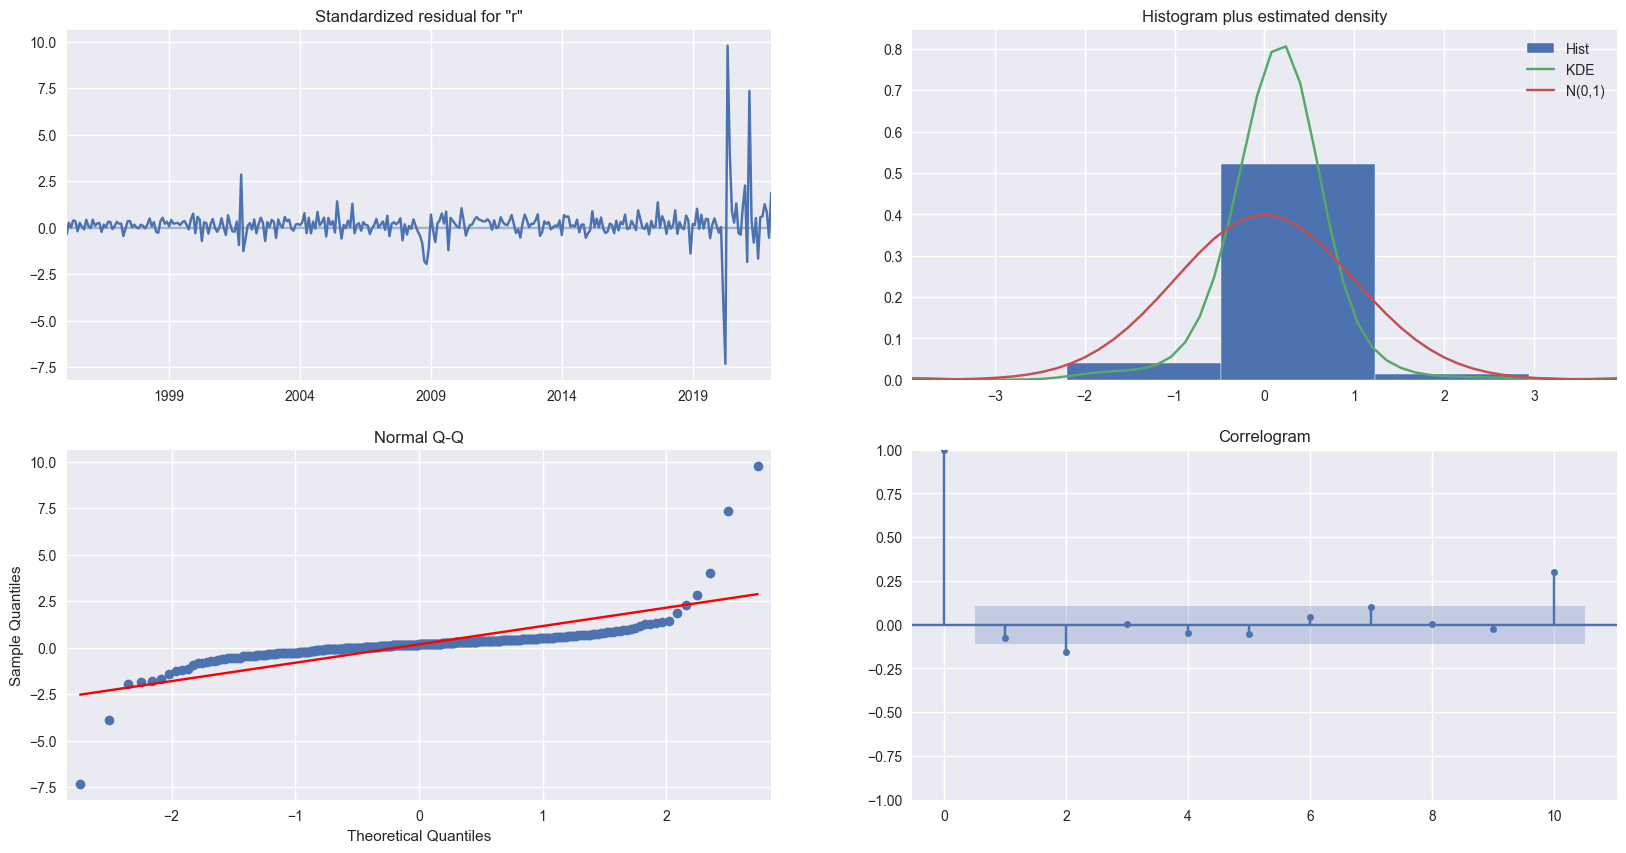

In [26]:
result_arima.plot_diagnostics()
print()

This code generates diagnostic plots for the fitted ARIMA model, helping to assess its adequacy and identify potential issues.

`result_arima.plot_diagnostics()` creates several subplots that visualize different aspects of the model's performance: 

*   **Standardized Residuals:** These are residuals divided by their standard deviation, used to check for patterns or non-constant variance (heteroscedasticity).
*   **Histogram of Standardized Residuals:** This plot assesses whether the residuals are approximately normally distributed.
*   **Q-Q Plot of Standardized Residuals:**  This plot compares the quantiles of the standardized residuals against the quantiles of a normal distribution, providing another way to check for normality.
*   **ACF and PACF Plots of Residuals:** These plots examine the autocorrelation and partial autocorrelation functions of the residuals. Ideally, these should show no significant correlations, indicating that the model has captured all the relevant patterns in the data.

The `print()` statement simply adds a blank line to the output after the diagnostic plots are displayed, improving readability by separating the plots from any subsequent code output.

## SARIMA

In [27]:
pipe2 = arima.AutoARIMA(stepwise=True, trace=1, error_action="ignore",
                        seasonal= True,  max_p=  2, max_q=2 , 
                      m= 12,  d= 1, start_P=1,  D=1, 
                      suppress_warnings=True)

pipe2.fit(y_train.values)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=6540.415, Time=0.35 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=6630.592, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=6589.714, Time=0.09 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.04 sec
 ARIMA(2,1,2)(0,1,1)[12]             : AIC=inf, Time=0.24 sec
 ARIMA(2,1,2)(1,1,0)[12]             : AIC=6581.141, Time=0.31 sec
 ARIMA(2,1,2)(2,1,1)[12]             : AIC=6541.604, Time=0.65 sec
 ARIMA(2,1,2)(1,1,2)[12]             : AIC=6541.796, Time=0.52 sec
 ARIMA(2,1,2)(0,1,0)[12]             : AIC=6624.044, Time=0.10 sec
 ARIMA(2,1,2)(0,1,2)[12]             : AIC=6540.134, Time=0.55 sec
 ARIMA(1,1,2)(0,1,2)[12]             : AIC=6538.272, Time=0.39 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=inf, Time=0.13 sec
 ARIMA(1,1,2)(1,1,2)[12]             : AIC=6539.939, Time=0.38 sec
 ARIMA(1,1,2)(1,1,1)[12]             : AIC=6538.569, Time=0.26 sec
 ARIMA(0,1,2)(0,1,2)[12]          

,start_p,2
,d,1
,start_q,2
,max_p,2
,max_d,2
,max_q,2
,start_P,1
,D,1
,start_Q,1
,max_P,2
,max_D,1


This code segment employs the `pmdarima` library to automatically identify and fit a Seasonal ARIMA (SARIMA) model to the retail sales training data.

An `AutoARIMA` object named `pipe2` is created, configured with parameters designed for seasonal time series analysis. The key differences from the previous `AutoARIMA` instantiation are:

*   `seasonal=True`: This explicitly tells the algorithm to consider and search for seasonal components in the data.
*   `m=12`:  This specifies the seasonal period – the number of observations in one season. A value of 12 suggests monthly seasonality (e.g., yearly patterns repeating every 12 months).
*   `d=1`, `start_P=1`, `D=1`: These parameters relate to the order of integration and seasonal differencing, respectively.  `d=1` indicates first-order non-seasonal differencing, while `start_P=1` and `D=1` specify first-order seasonal differencing.

The other parameters (`stepwise`, `trace`, `error_action`, `max_p`, `max_q`, `suppress_warnings`) function as described in the previous code block – controlling the search process, verbosity, error handling, and suppression of warnings. 

Finally, `pipe2.fit(y_train.values)` initiates the automated model selection and fitting procedure using the training data (`y_train`). The algorithm will explore different combinations of ARIMA and seasonal ARIMA orders to find a model that best fits the data, taking seasonality into account. The resulting optimal SARIMA model is stored within the `pipe2` object.

In [28]:
model_sarima = SARIMAX(
    y_train,
    order=(0, 1, 2),
    seasonal_order=(0, 1, 2, 12),
)
result_sarima = model_sarima.fit()
print(result_sarima.summary())


/Users/kbanachewicz/Documents/time-series-with-Konrad/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/kbanachewicz/Documents/time-series-with-Konrad/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                       retail_sales   No. Observations:                  325
Model:             SARIMAX(0, 1, 2)x(0, 1, 2, 12)   Log Likelihood               -3263.793
Date:                            Mon, 19 Jan 2026   AIC                           6537.585
Time:                                    23:23:56   BIC                           6556.300
Sample:                                01-01-1995   HQIC                          6545.065
                                     - 01-01-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0284      0.023     -1.237      0.216      -0.073       0.017
ma.L2         -0.1178      0.028   

This code segment explicitly defines and fits a Seasonal ARIMA (SARIMA) model to the retail sales training data, then displays a summary of the results.

A `SARIMAX` object named `model_sarima` is created with specific parameters defining both the non-seasonal and seasonal components of the model:

*   `y_train`: The time series data used for fitting the model.
*   `order=(0, 1, 2)`: This specifies the order of the non-seasonal ARIMA components: (p, d, q). Here, p=0 (no autoregressive term), d=1 (first-order differencing), and q=2 (second-order moving average term).
*   `seasonal_order=(0, 1, 2, 12)`: This defines the order of the seasonal ARIMA components: (P, D, Q, m). Here, P=0 (no seasonal autoregressive term), D=1 (first-order seasonal differencing), Q=2 (second-order seasonal moving average term), and m=12 (seasonal period – representing monthly data with yearly seasonality).

The `fit()` method is then called on `model_sarima` to estimate the model parameters based on the training data. The fitted model results are stored in the `result_sarima` object. 

Finally, `print(result_sarima.summary())` displays a detailed summary of the fitted SARIMA model. This includes estimated coefficients, standard errors, t-statistics, p-values, confidence intervals, and diagnostic statistics, providing insights into the model's performance and the significance of its parameters.

In [29]:
forecast_sarima = result_sarima.get_forecast(steps=len(y_test)).predicted_mean
forecast_metrics(y_test,forecast_sarima)

{'MAE': 11643.2, 'RMSE': 14543.32}

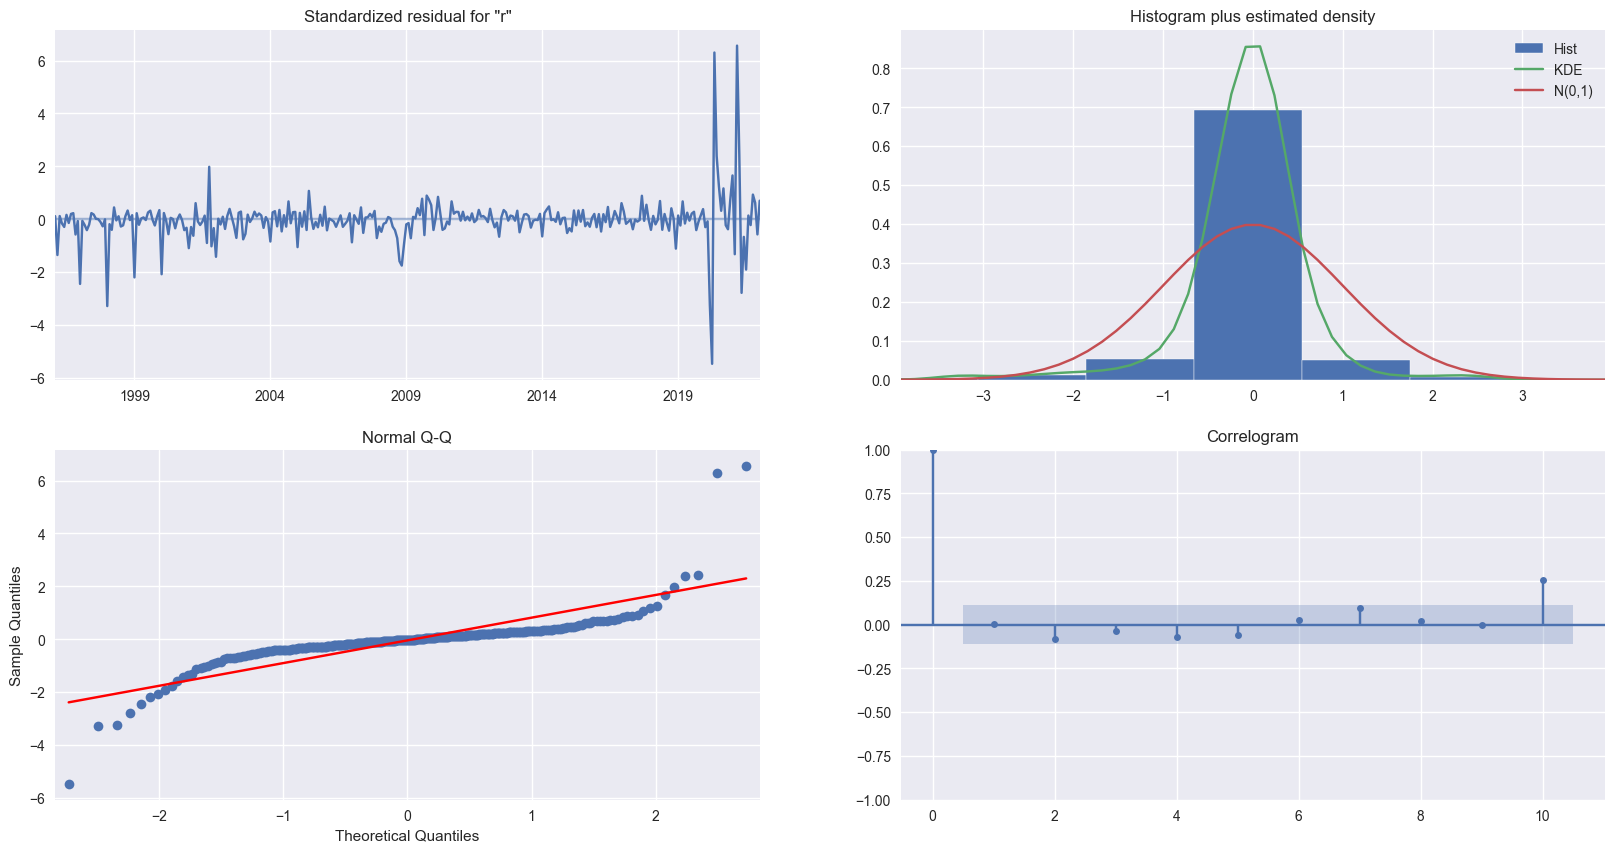

In [30]:
result_sarima.plot_diagnostics()
print()

## SARIMAX

In [31]:
model_sarimax1 = SARIMAX(
    y_train,
    exog=X_train,
    order=(0, 1, 2),
    seasonal_order=(0, 1, 2, 12),
)
result_sarimax1 = model_sarimax1.fit()
print(result_sarimax1.summary())


/Users/kbanachewicz/Documents/time-series-with-Konrad/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/kbanachewicz/Documents/time-series-with-Konrad/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                       retail_sales   No. Observations:                  325
Model:             SARIMAX(0, 1, 2)x(0, 1, 2, 12)   Log Likelihood               -3169.516
Date:                            Mon, 19 Jan 2026   AIC                           6353.031
Time:                                    23:23:57   BIC                           6379.232
Sample:                                01-01-1995   HQIC                          6363.503
                                     - 01-01-2022                                         
Covariance Type:                              opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
unemployment -5292.8852   1031.399     -5.132      0.000   -7314.389   -3271.381
cpi           1403.0038    24

/Users/kbanachewicz/Documents/time-series-with-Konrad/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


This code segment fits a Seasonal ARIMA with Exogenous Regressors (SARIMAX) model to the retail sales training data, incorporating unemployment and inflation as external factors influencing retail sales.

A `SARIMAX` object named `model_sarimax1` is created, similar to the previous SARIMA model, but with an important addition:

*   `exog=X_train`: This argument introduces exogenous variables – predictor variables that are not part of the time series itself but are believed to influence it. In this case, `X_train` contains the unemployment rate and inflation data for the training period, which will be used as regressors in the model.

The other parameters remain the same:

*   `y_train`: The retail sales time series (the dependent variable).
*   `order=(0, 1, 2)`:  Non-seasonal ARIMA order (p, d, q).
*   `seasonal_order=(0, 1, 2, 12)`: Seasonal ARIMA order (P, D, Q, m).

The `fit()` method is called on `model_sarimax1` to estimate the model parameters, now including coefficients for the exogenous variables. The fitted results are stored in `result_sarimax1`.

Finally, `print(result_sarimax1.summary())` displays a comprehensive summary of the fitted SARIMAX model. This summary includes not only the ARIMA and seasonal components but also the estimated coefficients, standard errors, t-statistics, and p-values for the unemployment and inflation variables, indicating their statistical significance in predicting retail sales.

In [32]:
forecast_sarimax1 = result_sarimax1.get_forecast(steps=len(y_test), exog=X_test).predicted_mean
forecast_metrics(y_test,forecast_sarimax1)

{'MAE': 17124.34, 'RMSE': 19863.89}

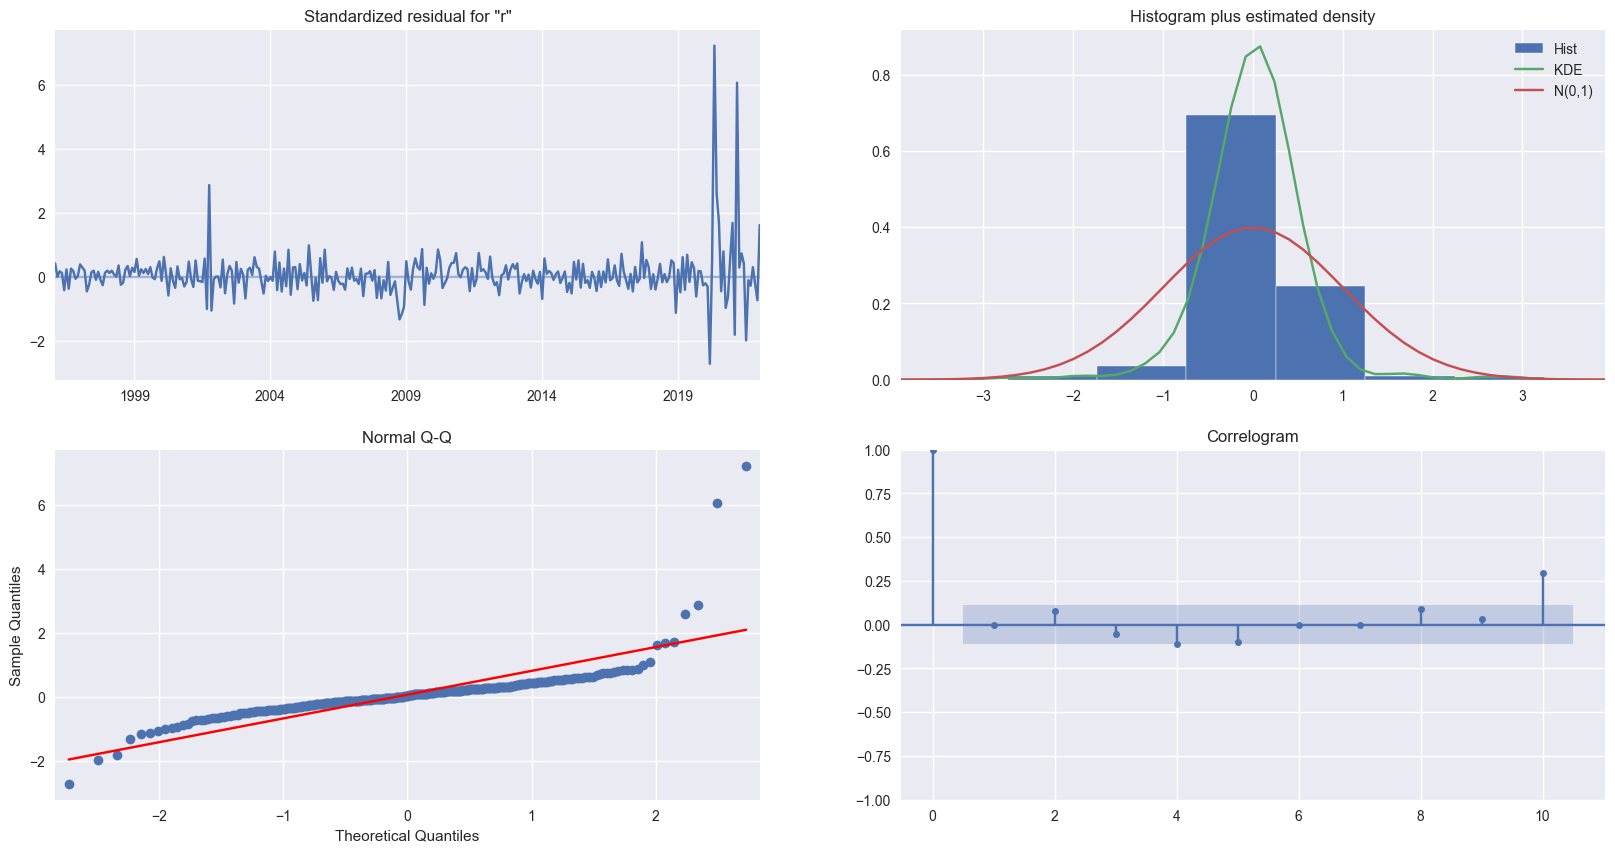

In [33]:
result_sarimax1.plot_diagnostics()
print()

In [34]:
model_sarimax2 = SARIMAX(
    y_train,
    exog=X_train,
    order=(0, 1, 2),
)
result_sarimax2 = model_sarimax2.fit()
print(result_sarimax2.summary())


                               SARIMAX Results                                
Dep. Variable:           retail_sales   No. Observations:                  325
Model:               SARIMAX(0, 1, 2)   Log Likelihood               -3257.312
Date:                Mon, 19 Jan 2026   AIC                           6524.624
Time:                        23:23:57   BIC                           6543.528
Sample:                    01-01-1995   HQIC                          6532.169
                         - 01-01-2022                                         
Covariance Type:                  opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
unemployment -5200.3780    313.278    -16.600      0.000   -5814.391   -4586.365
cpi           2227.5660    332.214      6.705      0.000    1576.438    2878.694
ma.L1           -0.0079      0.026     -0.30

/Users/kbanachewicz/Documents/time-series-with-Konrad/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/kbanachewicz/Documents/time-series-with-Konrad/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [35]:
forecast_sarimax2 = result_sarimax2.get_forecast(steps=len(y_test), exog=X_test).predicted_mean
forecast_metrics(y_test,forecast_sarimax2)

{'MAE': 16774.35, 'RMSE': 19085.68}

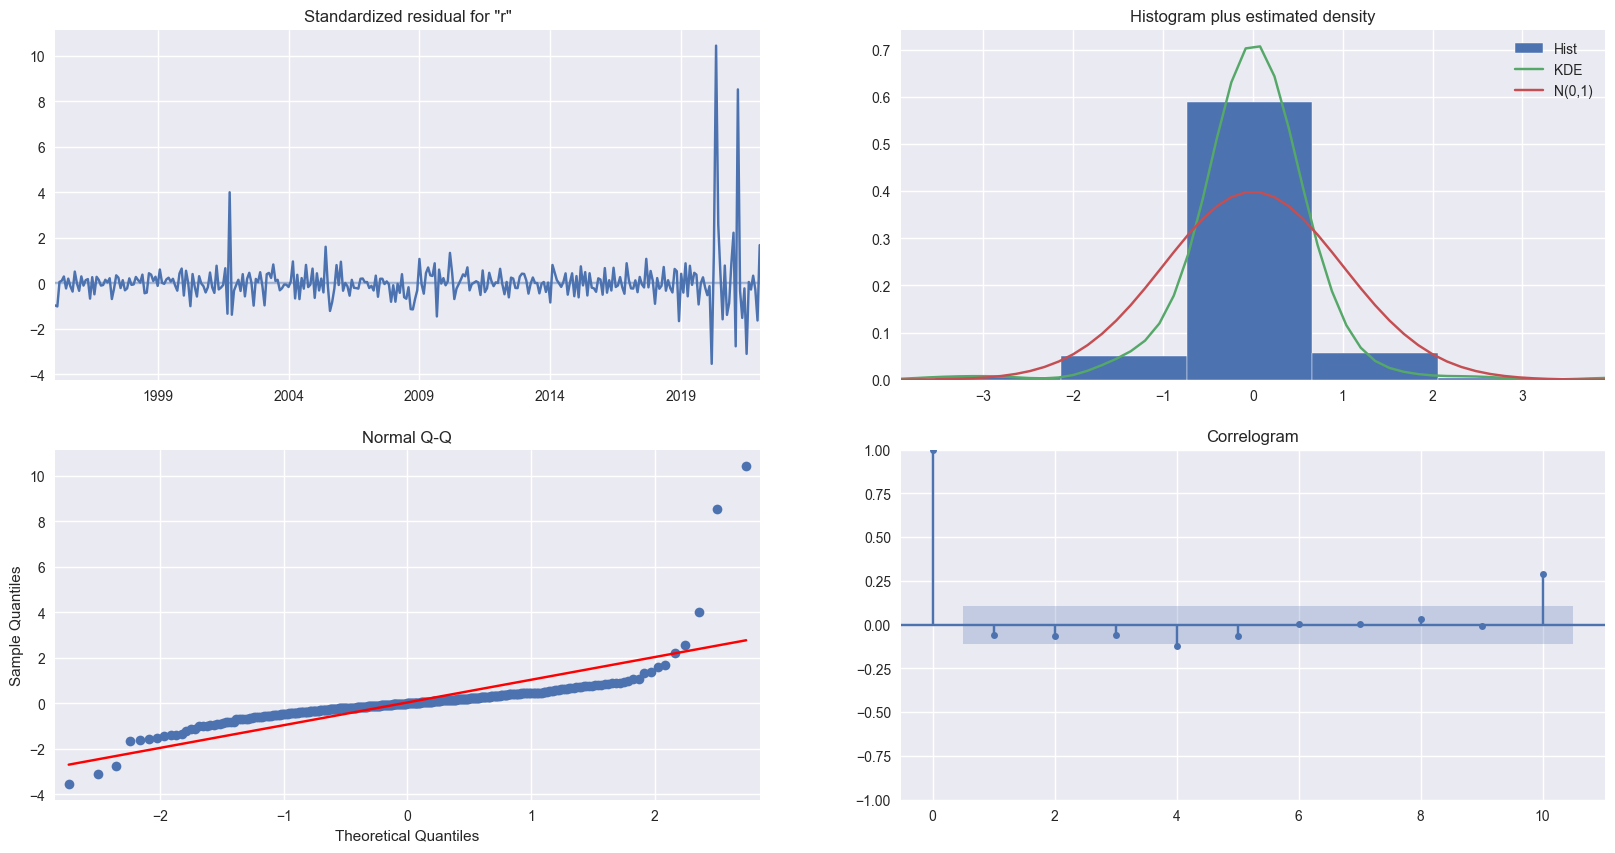

In [36]:
result_sarimax2.plot_diagnostics()
print()